In [2]:
import pandas_datareader.data as web
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Premise

In this section, I will take a different approach compared to the momentum strategy. Instead of relying on well-known indicators like RSI, Bollinger Bands, or incremental stop losses, I will develop a strategy purely based on the principles of mean reversion. My goal is to introduce some mathematical concepts—albeit in a simplified way due to time constraints—and demonstrate their practical application. While this will not be a comprehensive or rigorous explanation of the underlying theories, which are the subject of extensive research, I aim to provide intuition and showcase my understanding of these ideas.

## Mathematical rigor, explanations and applications

What we’ve covered up to this point is valuable and provides a solid foundation for how it is possible to model and evaluate trading strategies. However, behind all of this lie important mathematical principles. Furthermore, if we dive deeper into physics, we can find systems that physicists have learned to model with high precision. These models - grounded in concepts such as momentum, equilibrium, and mean reversion - can often be adapted and applied in our search for profitable trades. By borrowing from the well-established mathematical frameworks in physics, we may be able to develop more robust and theoretically sound trading models, bridging the gap between empirical strategy development and fundamental laws of behavior seen in complex systems.



Before jumping into **Mean reversion** I would like to introduce a concept from physics and differential equations which is a good mathematical explanation of what we are going to perform.

## Using the harmonic oscillator as a model for mean reversion

The harmonic oscillator is a well-understood system in physics where a particle tends to return to its equilibrium position due to a restoring force proportional to its displacement (Hooke's law:  
**$F = -kx$**).

This behavior closely mirrors what we see in mean-reverting assets: when prices deviate from their "fair value" (mean), a restoring mechanism tends to bring them back.

### mathematical analogy

The differential equation of the harmonic oscillator is:

$$
\frac{d^2x}{dt^2} + \omega^2 x = 0
$$

In this analogy:
- $x(t)$: deviation of price from the mean  
- $\omega$: strength of the restoring force  
- The solution: $x(t) = A \cos(\omega t + \phi)$

This suggests that price movements can be modeled as oscillations around a central tendency, which is the foundation of many mean reversion strategies.


If we wanted to we could also give some more explanation as to how those are solved:

## Simple Harmonic Oscillator and Its Solution

The differential equation of a simple harmonic oscillator is:

$$
\frac{d^2x}{dt^2} + \omega^2 x = 0
$$

This is a second-order linear homogeneous differential equation with constant coefficients. Its characteristic equation is:

$$
r^2 + \omega^2 = 0
$$

Solving this gives complex roots:

$$
r = \pm i\omega
$$

The general solution is:

$$
x(t) = C_1 e^{i\omega t} + C_2 e^{-i\omega t}
$$

Now using Euler's formula:

$$
e^{i\omega t} = \cos(\omega t) + i \sin(\omega t)
$$

So the solution becomes a combination of sine and cosine:

$$
x(t) = A \cos(\omega t) + B \sin(\omega t)
$$

Or, equivalently:

$$
x(t) = A \cos(\omega t + \phi)
$$



What we did here makes use of differential equations and complex analysis. This is the **undampled simple harmonic oscillator.** In practice there is something else that might be seen and it is the **damped** version

## Damped second-order differential equation

The damped oscillator differential equation can be written as:

$$
y'' + y' + y = 0
$$

This is a second-order linear differential equation with damping represented by the first derivative term $ y' $.

## Characteristic equation

To solve this, assume solutions of the form $ y = e^{\lambda t} $. Substituting into the differential equation gives the characteristic equation:

$$
\lambda^2 + \lambda + 1 = 0
$$


$$
\lambda = \frac{-1 \pm \sqrt{1 - 4}}{2} = \frac{-1 \pm \sqrt{-3}}{2} = -\frac{1}{2} \pm i \frac{\sqrt{3}}{2}
$$

## General solution

Because the roots are complex conjugates with a negative real part, the general solution takes the form of a **damped oscillation**:

$$
y(t) = e^{-\frac{1}{2}t} \left( A \cos\left( \frac{\sqrt{3}}{2} t \right) + B \sin\left( \frac{\sqrt{3}}{2} t \right) \right)
$$

- The term $e^{-\frac{1}{2}t} $ represents exponential decay (damping).  
- The cosine and sine terms represent oscillations with angular frequency $ \frac{\sqrt{3}}{2}$

## Interpretation

This solution shows oscillations whose amplitude decreases exponentially over time — a good model for processes in finance where prices or other quantities revert to a mean but oscillate less and less as time progresses.
mm

![Oscilator](https://tse2.mm.bing.net/th/id/OIP.tMbnFtAs-wYSnMYcDEMcQgHaD-?r=0&rs=1&pid=ImgDetMain&o=7&rm=3)

#### Note
While this model is useful and often applied in finance, it is important to recognize that real markets are much more complex and cannot be perfectly modeled. Therefore, we typically rely on stochastic differential equations and probabilistic methods to better capture market behavior and uncertainty.

Before we start, instead of approaching mean reversion purely from a deterministic perspective like the momentum strategy, I will explore stochastic and probabilistic models. This will be more interesting since the oposite approach would be close to the one we did in the momentum strategy, just requiring some other metrics. The mathematical approach better captures the randomness and uncertainty inherent in financial markets and allows for a more realistic modeling of mean-reverting behavior.

### Introducing SDE
The idea behind Stochastic differential equations is that in the real world many systems, especially in finance, it is difficult to work with deterministic differential equations alone. We need a factor for randomness. To model such systems where we have randomness, we need to add a **Brownian motion.**

### General Form

$$
dx_t = \mu(x_t, t)\, dt + \sigma(x_t, t)\, dW_t
$$

Where:
- $x_t$ is the stochastic process
- $\mu(x_t, t)$ is the **drift** term (the average trend)
- $\sigma(x_t, t)$ is the **diffusion** term (the volatility)
- $W_t$ is a **Wiener process** (or standard Brownian motion)

## Key Concepts

- **Drift ($\mu$):**  
  Describes the average rate and direction of change in the process over time.

- **Diffusion ($\sigma$):**  
  Represents the random fluctuations and noise in the process.

- **Wiener Process ($W_t$):**  
  A continuous-time stochastic process with the properties:
  - $W_0 = 0$
  - Independent increments
  - $W_t - W_s \sim \mathcal{N}(0, t - s)$ for $t > s$
  - Continuous paths

## Ornstein-Uhlenbeck (OU)
Let's have some fun. One of the most popular and realistic options for such mean-reverting behavior and stochastic differential equations is the **Ornstein-Uhlenbeck.** Let us take a look at the model:

$$
dX_t = \theta (\mu - X_t)\,dt + \sigma\,dW_t
$$

where:

- $X_t$ is the value of the process at time $t$
- $\mu$ is the long-term mean
- $\theta > 0$ is the speed of mean reversion
- $\sigma > 0$ is the volatility
- $W_t$ is a Wiener process (standard Brownian motion)

### Discretized Version (Euler-Maruyama Approximation)

To simulate this process numerically, we can use the Euler-Maruyama scheme:

$$
X_{t+\Delta t} = X_t + \theta(\mu - X_t)\Delta t + \sigma \sqrt{\Delta t}\cdot Z_t
$$

where $Z_t \sim \mathcal{N}(0, 1)$ is standard normal noise and $\Delta t$ is the time step size.

#### Note  
We are going to use the approximation because **we are working numerically on a computer** and cannot solve the continuous stochastic differential equation analytically.  
The Euler-Maruyama method allows us to simulate the behavior of the process in discrete time steps, which is essential for computational modeling.

**Now I will try to simulate such movement, no data needed.**

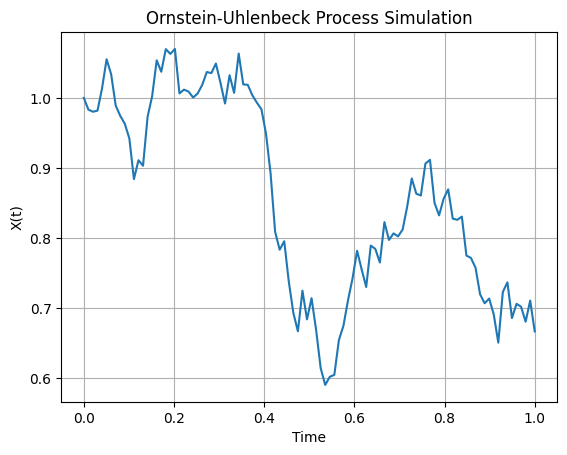

In [3]:

# Parameters
mu = 0        
theta = 0.7   
sigma = 0.3   
X0 = 1        
T = 1        
dt = 0.01   
N = int(T/dt)

# Initialization
X = np.zeros(N)
X[0] = X0

# Generate Wiener increments
np.random.seed(38)
epsilon = np.random.normal(0, 1, N)

# Simulate the OU process
for t in range(1, N):
    X[t] = X[t-1] + theta*(mu - X[t-1])*dt + sigma*np.sqrt(dt)*epsilon[t]

# Plot
plt.plot(np.linspace(0, T, N), X)
plt.title("Ornstein-Uhlenbeck Process Simulation")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.grid(True)
plt.show()


From the plot above it is visible that we were able to simulate the process. However, the next question that we would ask is: how do we use all this knowledge on real data?

## Choice of asset

Firstly, we need to find the asset, assuming that it is mean-reverting. Some candidates might be:
- Volatility indices: The **VIX (Volatility Index)** tends to revert to a long-term average since volatility spikes are temporary and tend to calm over time.
- Pairs tradin in equities: The price ratio or spread between two historically correlated stocks (e.g., Coca-Cola and Pepsi) often exhibits mean reverting characteristics. This is the foundation of pairs trading strategies.

for our example we will take a look at: **10-Year US Treasury Yield - It tends to mean revert due to monetary policy and economic cycles.**

In [4]:


start = datetime.datetime(2010, 1, 4)
end = datetime.datetime.today()

# 10-Year Treasury Constant Maturity Rate (DGS10)
data = web.DataReader('DGS10', 'fred', start, end)

print(data.head())


            DGS10
DATE             
2010-01-04   3.85
2010-01-05   3.77
2010-01-06   3.85
2010-01-07   3.85
2010-01-08   3.83


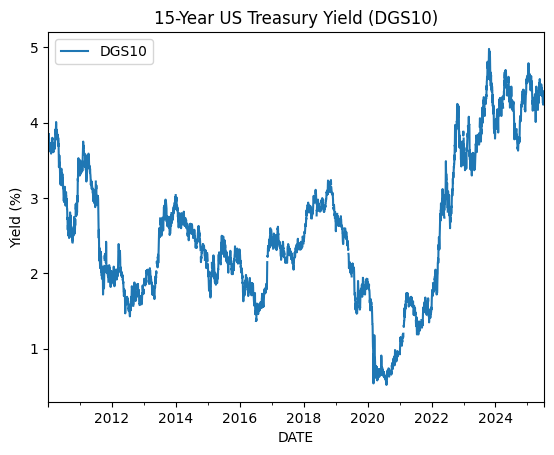

In [5]:

data.plot(title='15-Year US Treasury Yield (DGS10)')
plt.ylabel('Yield (%)')
plt.show()

In [6]:
data_clean = data.dropna(subset=['DGS10'])  # drop rows where 'DGS10' is NaN
yields_clean = data_clean['DGS10'].values
dates_clean = data_clean.index  # aligned dates with the clean yields
data_clean.head()

,DGS10
DATE,
2010-01-04,3.85
2010-01-05,3.77
2010-01-06,3.85
2010-01-07,3.85
2010-01-08,3.83


In [7]:
 dt = 1/252 # suppose we do 252 trades per day

**Now our goal will be to find the parameters (theta,mu,sigma) that model the best this data. We are going to use the **negative log-likelihood function for MLE.**

The log-likelihood function of the discretized Ornstein-Uhlenbeck (OU) process is:

$$
\log L(\theta, \mu, \sigma) = -\frac{n}{2} \log(2\pi \sigma_v^2) - \sum_{i=1}^{n} \frac{\left(X_i - X_{i-1} e^{-\theta \Delta t} - \mu (1 - e^{-\theta \Delta t})\right)^2}{2 \sigma_v^2}
$$

where the conditional variance is given by:

$$
\sigma_v^2 = \frac{\sigma^2}{2\theta} \left(1 - e^{-2\theta \Delta t}\right)
$$


In [8]:

def ou_neg_log_likelihood(params, data, dt):
    theta, mu, sigma = params
    if theta <= 0 or sigma <= 0:
        return np.inf  # parameters must be positive

    n = len(data)
    # Expected mean and variance
    m = data[:-1] * np.exp(-theta*dt) + mu * (1 - np.exp(-theta*dt))
    v = (sigma**2) / (2*theta) * (1 - np.exp(-2*theta*dt))
    
    # Negative log-likelihood
    nll = 0.5 * np.sum(np.log(2 * np.pi * v) + ((data[1:] - m)**2) / v)
    return nll


In [9]:
init_params = [0.5, np.mean(yields_clean), np.std(yields_clean)/2]

result = minimize(ou_neg_log_likelihood, init_params, args=(yields_clean, dt),
                  bounds=[(1e-5, None), (None, None), (1e-5, None)])

theta_est, mu_est, sigma_est = result.x
print(f"Estimated parameters:\n theta={theta_est}\n mu={mu_est}\n sigma={sigma_est}")

Estimated parameters:
 theta=0.3321073465081677
 mu=2.660439680224759
 sigma=0.8578980315485104


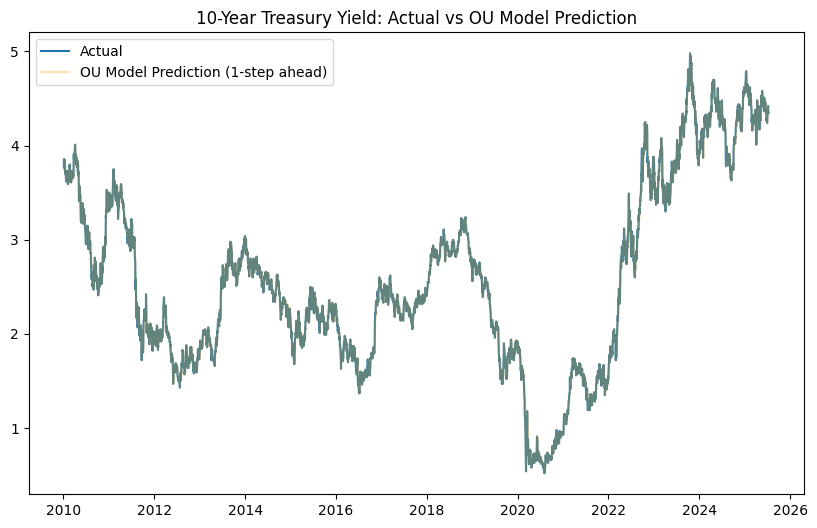

In [10]:
predicted = yields_clean[:-1] * np.exp(-theta_est*dt) + mu_est * (1 - np.exp(-theta_est*dt))

plt.figure(figsize=(10,6))
plt.plot(dates_clean, yields_clean, label='Actual')
plt.plot(dates_clean[1:], predicted, label='OU Model Prediction (1-step ahead)',color="orange",alpha=0.3)
plt.legend()
plt.title('10-Year Treasury Yield: Actual vs OU Model Prediction')
plt.show()


From the plot above it is visible that we were able to model everything very well. Both graphs are almost identical. Now comes the question, how would it perform on unseen data. For this purpose we need to make a train test split and try it out

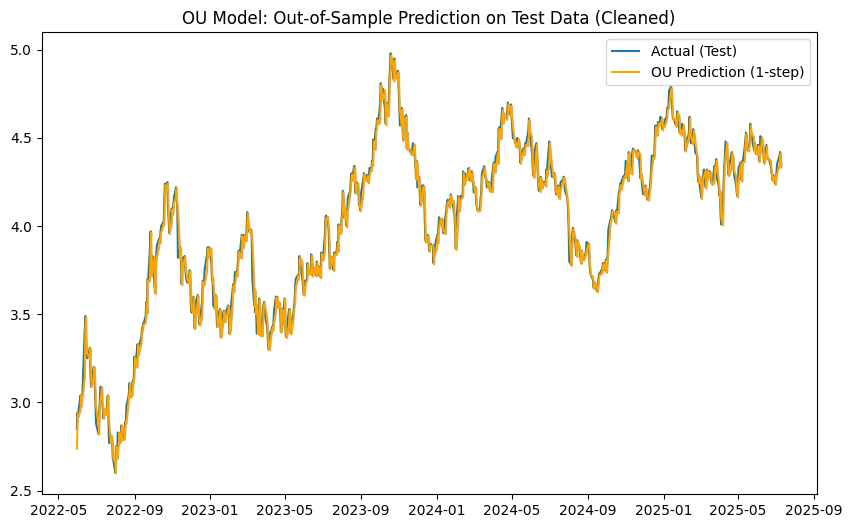

In [11]:
# 1. Split data
split_idx = int(0.8 * len(yields_clean))
train_data = yields_clean[:split_idx]
test_data = yields_clean[split_idx:]
train_dates = dates_clean[:split_idx]
test_dates = dates_clean[split_idx:]

# 2. Fit OU model on training data
result = minimize(ou_neg_log_likelihood, init_params, args=(train_data, dt),
                  bounds=[(1e-5, None), (None, None), (1e-5, None)])
theta_est, mu_est, sigma_est = result.x

# 3. Predict on test data (1-step ahead)
test_pred = []
last_x = train_data[-1]

for i in range(len(test_data)):
    pred = last_x * np.exp(-theta_est * dt) + mu_est * (1 - np.exp(-theta_est * dt))
    test_pred.append(pred)
    last_x = test_data[i]   # update with actual value

# 4. Plot
plt.figure(figsize=(10, 6))
plt.plot(test_dates, test_data, label='Actual (Test)')
plt.plot(test_dates, test_pred, label='OU Prediction (1-step)', color='orange')
plt.legend()
plt.title('OU Model: Out-of-Sample Prediction on Test Data (Cleaned)')
plt.show()


Now it is important to notice that this is used for **model validation and not forecasting.** This is due to the fact that we are constantly updating ```last_x = test_data[i]```

Now we could try to add noise and see where this takes us.

In [12]:


# 1. Load your data (make sure 'data' has a DateTime index and 'DGS10' column)
# data = pd.read_csv('your_data.csv', parse_dates=['DATE'], index_col='DATE')

# 2. Drop missing values
data_clean = data['DGS10'].dropna()

# 3. Define training and testing period
train_end = '2025-05-31'
test_start = '2025-06-01'
test_end = '2025-06-30'

train_data = data_clean.loc[:train_end]
test_data = data_clean.loc[test_start:test_end]
test_dates = test_data.index

dt = 1 / 252  # Daily frequency


What we did now was to take all the data up to a certain point for training data, make test data and decide on the daily trading frequency(what the best daily frequency should be is to be considered)

In [13]:

# 4. Define OU negative log-likelihood
def ou_neg_log_likelihood(params, data, dt):
    theta, mu, sigma = params
    if theta <= 0 or sigma <= 0:
        return np.inf
    m = data[:-1] * np.exp(-theta * dt) + mu * (1 - np.exp(-theta * dt))
    v = (sigma**2) / (2 * theta) * (1 - np.exp(-2 * theta * dt))
    nll = 0.5 * np.sum(np.log(2 * np.pi * v) + ((data[1:] - m)**2) / v)
    return nll

# 5. Fit the model
init_params = [0.1, train_data.mean(), 0.1]  # Initial guess
result = minimize(ou_neg_log_likelihood, init_params, args=(train_data.values, dt),
                  bounds=[(1e-5, None), (None, None), (1e-5, None)])
theta_est, mu_est, sigma_est = result.x

print(f"Estimated parameters:\nTheta: {theta_est:.4f}\nMu: {mu_est:.4f}\nSigma: {sigma_est:.4f}")


Estimated parameters:
Theta: 0.3302
Mu: 2.6607
Sigma: 0.8585


Here we are defining our function for the ```log_likelihood``` and then fitting it to the data we have, This way we find the $\theta$, $\mu$ and $\sigma$ values.

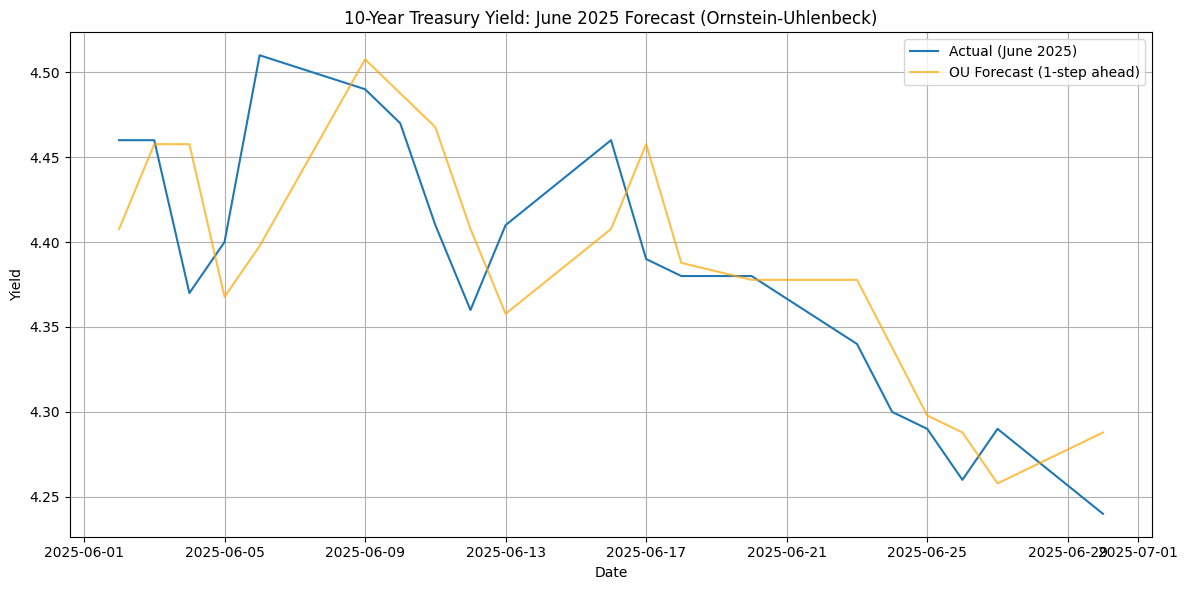

In [14]:

# 6. Forecast for each day in June (recursive 1-step)
forecast = []
last_x = train_data.iloc[-1]

for date in test_dates:
    pred = last_x * np.exp(-theta_est * dt) + mu_est * (1 - np.exp(-theta_est * dt))
    forecast.append(pred)
    last_x = test_data[date] if date in test_data else pred  # update with actual if available

# 7. Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test_data, label='Actual (June 2025)')
plt.plot(test_dates, forecast, label='OU Forecast (1-step ahead)', color='orange', alpha=0.7)
plt.title('10-Year Treasury Yield: June 2025 Forecast (Ornstein-Uhlenbeck)')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


For the last part what we are doing is more of a **hybrid model** where we predict the next day, take information about that day when we know it and from that we predict the next day, This however is not **real forecasting.** If we used the data from the predicted day, to predict the next one, it would look like this:

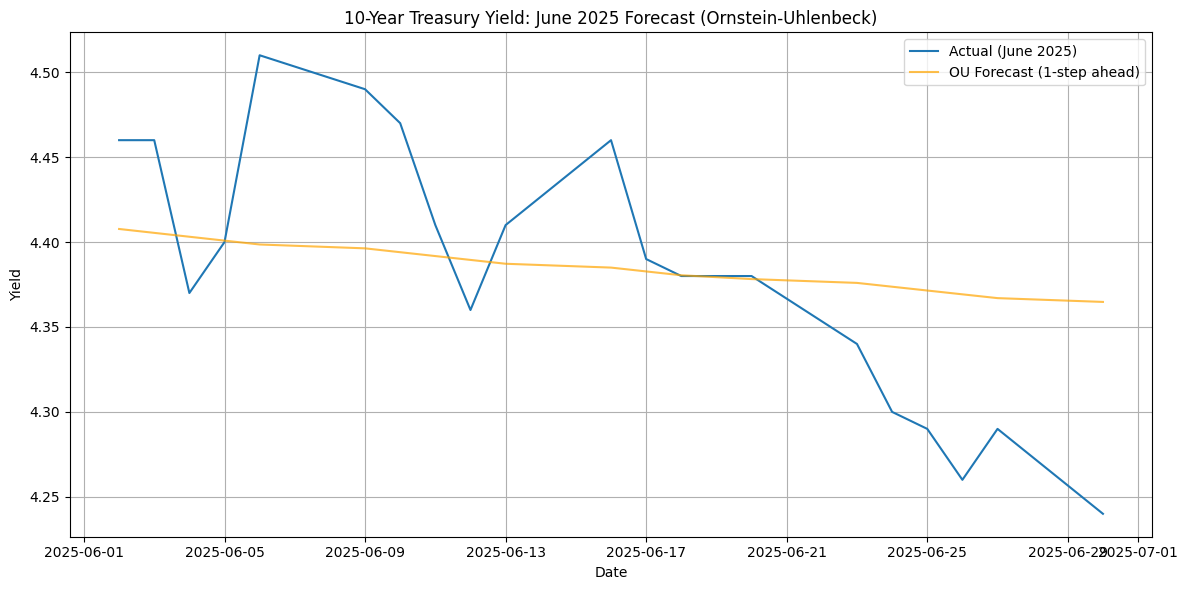

In [15]:
last_x = train_data.iloc[-1]
forecast = []
for _ in range(len(test_dates)):
    pred = last_x * np.exp(-theta_est * dt) + mu_est * (1 - np.exp(-theta_est * dt))
    forecast.append(pred)
    last_x = pred 
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test_data, label='Actual (June 2025)')
plt.plot(test_dates, forecast, label='OU Forecast (1-step ahead)', color='orange', alpha=0.7)
plt.title('10-Year Treasury Yield: June 2025 Forecast (Ornstein-Uhlenbeck)')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The result that we got is... quite disappointing. **Although Ornstein-Uhlenbeck model is elegant in theory, it is too simplistic for real-world financial time series like yields.** This is well known problem to the OU but **nevertheless it is worth looking at it since it provides information as to how we could use differential equations.** 

It is also important to say why this actually happens. If we look at the equation of the algorithm:
$$X_{t+1} = X_t \cdot e^{-\theta \cdot \Delta t} + \mu \cdot \left(1 - e^{-\theta \cdot \Delta t} \right)$$

We would notice that if we used  ```last_x = pred``` we are going to slowly converge to the mean.

This means that we capture:
1. how the market tends to revert to a long-term mean.
2. that short-term yield predictions based purely on mean-reversion are often flat or overly smooth.

But we don't capture:
- real short-term market behavior (noise, jumps, volatility)
- momentum
- reactions to news or events

## Oscillator differential equations

Earlier, we discussed Hooke’s law and damped harmonic oscillators. Now is a great time to revisit those concepts. As we observed, the Ornstein-Uhlenbeck model effectively captures mean reversion but fails to account for momentum or cyclical behavior in the data. To address this, we can consider implementing oscillator models, which naturally incorporate both mean reversion and oscillatory dynamics.
$$ 
\frac{d^2 y}{dt^2} + \frac{dy}{dt} + y = 0
$$

This is the general equation. However we are going to discretisize it making the $dt$ to $\Delta t$. Also we are going to center it on the mean and add a denominator adjusting for the balance of the damping property. After some transformation we derive:

$$x_{t+1} = \frac{2 x_t - \left(1 - 2 \gamma \Delta t \right) x_{t-1} - \omega^2 \Delta t^2 (x_t - \mu)}{1 + 2 \gamma \Delta t}$$



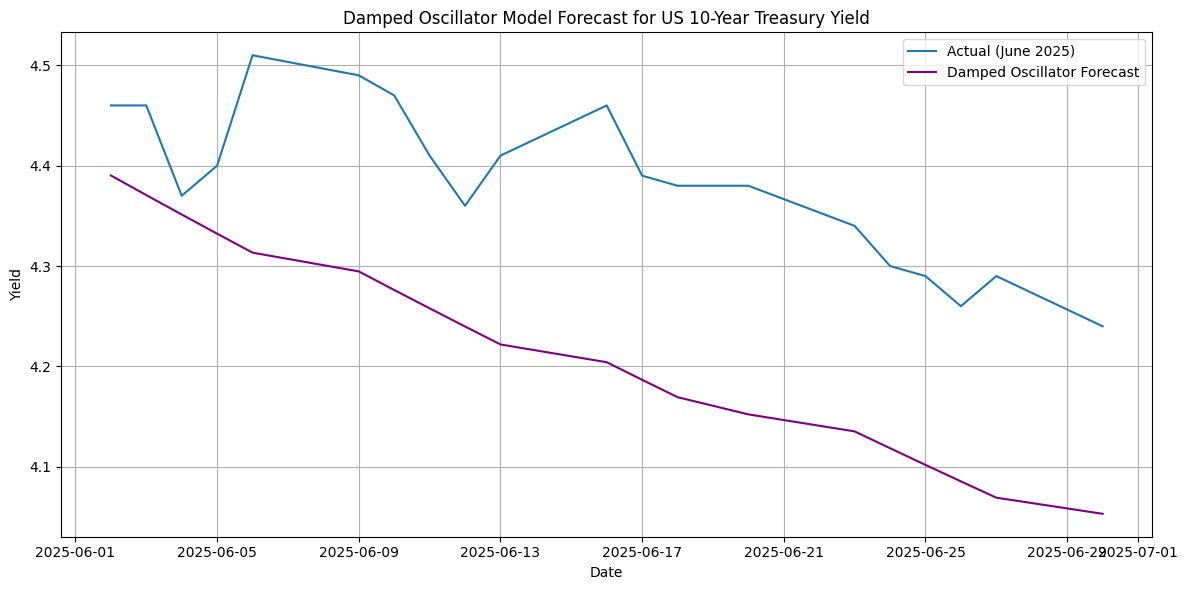

In [17]:

dt = 1 / 252


train_data = data_clean.loc[:'2025-05-31']
test_data = data_clean.loc['2025-06-01':'2025-06-30']
test_dates = test_data.index

mu = train_data.mean()


x_tm1 = train_data.iloc[-2]
x_t = train_data.iloc[-1]  

# We can optimize those later if we want to...
gamma = 10  # damping
omega = 10.0  # angular frequency

forecast = []

for _ in range(len(test_dates)):
 # equation
    x_tp1 = (2 * x_t - (1 - 2 * gamma * dt) * x_tm1 - omega**2 * dt**2 * (x_t - mu)) / (1 + 2 * gamma * dt)

    forecast.append(x_tp1)
    # update previous values
    x_tm1, x_t = x_t, x_tp1

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test_data, label='Actual (June 2025)')
plt.plot(test_dates, forecast, label='Damped Oscillator Forecast', color='purple')
plt.title('Damped Oscillator Model Forecast for US 10-Year Treasury Yield')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The forecast from the discretized damped harmonic oscillator model produces a decreasing line that converges toward the mean $\mu$ This indicates the system exhibits strong damping leading to mean reversion without noticeable oscillations. The absence of visible oscillations suggests that the chosen parameters or the discretization may overdamp the system, preventing the expected oscillatory behavior. Thus, while the model captures mean reversion, it fails to replicate the characteristic oscillations of a damped harmonic oscillator in this case.

**At this point I am not going to further investigate and try to modify the model. The main idea was to show some mathematical and physical intuitions and how they might and could be applied in finance, demonstrating the potential and limitations of using physics-inspired models like the damped harmonic oscillator for financial time series forecasting. Additionally, I introduced stochastic differential equations to capture randomness inherent in financial data, highlighting a bridge between deterministic physics models and the stochastic nature of markets.**

## Resources
- https://www.bing.com/search?q=damped+harmonic+oscilator+on+finance&cvid=2ab0ffc0eb974a2388523970c7c0fcff&gs_lcrp=EgRlZGdlKgYIABBFGDkyBggAEEUYOTIGCAEQABhAMgYIAhAAGEAyBggDEAAYQDIGCAQQABhAMgYIBRAAGEAyBggGEAAYQDIGCAcQABhAMgYICBAAGEDSAQg2MjY0ajBqOagCCLACAQ&FORM=ANAB01&adppc=EDGEESS&PC=W069
- https://www.bing.com/search?qs=SS&pq=stochastic+d&sk=CSYN1&sc=16-12&q=stochastic+differential+equations&cvid=eb15157cd4004ee894d06e98c5062b83&gs_lcrp=EgRlZGdlKgkIABAjGCcY-QcyCQgAECMYJxj5BzIGCAEQRRg5MgYIAhAAGEAyBggDEAAYQDIGCAQQABhAMgYIBRAAGEAyBggGEAAYQDIGCAcQABhAMgYICBAAGEDSAQg0MzEyajBqOagCCLACAQ&FORM=ANAB01&adppc=EDGEESS&PC=W069
- https://www.quantstart.com/articles/ornstein-uhlenbeck-simulation-with-python/
- https://www.sciencedirect.com/science/article/abs/pii/S0378437120301321#:~:text=A%20financial%20asset%20price-forecasting%20model%20based%20on%20damped,price%2C%20besides%20inertia%20and%20dissipation%2C%20could%20take%20place.